In [1]:
import os
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [2]:
%%capture output
pip install langgraph langchain langchain_openai

In [13]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
import operator

In [5]:
model = ChatOpenAI(model='gpt-4o-mini')


In [6]:
# We are creatign an Evaluation schema to make sure that LLM outputs within this format only.
# We have also set a rule that score has to be greater than equal to 0 ad less than equal to 1

class EvaluationSchema(BaseModel):
  feedback: str = Field(description = 'Detailed Feedback for the Essay')
  score: int = Field(description = 'Score out of 10', ge=0, le=10)


In [7]:
# We have created a structured model here, which will output in a structured format as specified
structured_model = model.with_structured_output(EvaluationSchema)


In [9]:
essay = "India is emerging as a global hub for Artificial Intelligence (AI), leveraging its vast talent pool, digital infrastructure, and innovative startups. The government’s “AI for All” initiative promotes inclusive growth through AI in sectors like healthcare, agriculture, education, and smart governance. Indian tech companies and research institutes are driving breakthroughs in natural language processing, computer vision, and AI ethics. With growing collaborations between academia and industry, India aims to position itself as a leader in responsible and scalable AI solutions. By combining technological innovation with human-centric values, India is shaping the future of AI for global good."

In [10]:
prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'

In [11]:
structured_model.invoke(prompt)

EvaluationSchema(feedback="The essay presents a strong overview of India's position in the field of Artificial Intelligence, highlighting key initiatives, sectors impacted, and the collaborative efforts between academia and industry. The language is clear and concise, making it easy for the reader to follow the argument. However, it could benefit from more detailed examples or statistics to substantiate the claims made, particularly regarding specific breakthroughs and the effects of the ‘AI for All’ initiative. Additionally, there could be a stronger concluding statement to reinforce the significance of India’s role in the global AI landscape.", score=8)

In [20]:
class UPSCState(TypedDict):
  essay: str
  language_feedback: str
  analysis_feedback: str
  clarity_feedback: str
  overall_feedback: str
  # Individual scores will have a list of scores generated on the basis of various parameters, whioch ultimately will be added to create final score
  # We do this to avoid override behavavior by using a reducer function, which is , in this case
  # [6] + [7] + [9]
  individual_scores: Annotated[list[int], operator.add]
  avg_score: float



In [21]:
def evaluate_language(state: UPSCState):
  prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}'
  output = structured_model.invoke(prompt)
  return {'language_feedback': output.feedback, 'individual_scores': [output.score]}


In [22]:
def evaluate_analysis(state: UPSCState):
  prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}'
  output = structured_model.invoke(prompt)
  return {'analysis_feedback': output.feedback, 'individual_scores': [output.score]}

In [23]:
def evaluate_thought(state: UPSCState):
  prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state['essay']}'
  output = structured_model.invoke(prompt)
  return {'clarity_feedback': output.feedback, 'individual_scores': [output.score]}

In [24]:
def final_evaluation(state: UPSCState):
  # Summary Feedback
  prompt = f'Based on the following feedbacks, create a summarized feedback \n Language feedback - {state["language_feedback"]} \n Depth of Analysis feedback - {state["analysis_feedback"]} \n Clarity of Thought feedback - {state["clarity_feedback"]}'
  overall_feedback = model.invoke(prompt).content

  # Calculate Average
  avg_score = sum(state['individual_scores'])/len(state['individual_scores'])
  return {'overall_feedback': overall_feedback, 'avg_score': avg_score}


In [29]:

graph = StateGraph(UPSCState)

graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_thought', evaluate_thought)
graph.add_node('final_evaluation', final_evaluation)


# Edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_thought')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')

graph.add_edge('final_evaluation', END)
workflow = graph.compile()

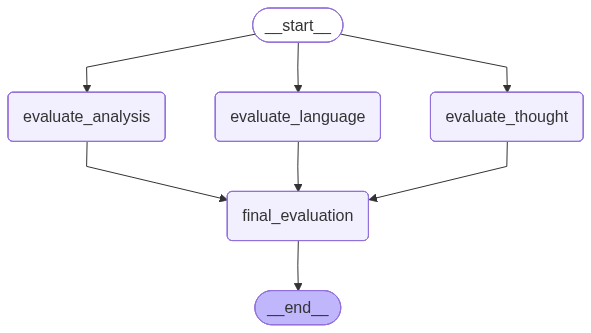

In [30]:
workflow

In [31]:
# Execute
initial_state = {
    'essay': essay
}

In [32]:
workflow.invoke(initial_state)

{'essay': 'India is emerging as a global hub for Artificial Intelligence (AI), leveraging its vast talent pool, digital infrastructure, and innovative startups. The government’s “AI for All” initiative promotes inclusive growth through AI in sectors like healthcare, agriculture, education, and smart governance. Indian tech companies and research institutes are driving breakthroughs in natural language processing, computer vision, and AI ethics. With growing collaborations between academia and industry, India aims to position itself as a leader in responsible and scalable AI solutions. By combining technological innovation with human-centric values, India is shaping the future of AI for global good.',
 'language_feedback': 'The essay presents a clear and concise overview of India\'s role in the emergence of Artificial Intelligence. The language is formal and appropriate for the topic, with a logical structure that highlights key initiatives and contributions. The use of specific example